In [78]:
import numpy as np
import matplotlib as plt
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [148]:
from IMV_LSTM.networks import IMVTensorLSTM

In [145]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [128]:
data = pd.read_csv("TS_datasets/pm25/PRSA_data_2010.1.1-2014.12.31.csv")

In [129]:
cbwd = pd.get_dummies(data['cbwd'])
cbwd.columns = ["cbwd_{}".format(i) for i in range(cbwd.shape[1])]
data = pd.concat([data, cbwd], axis=1)

In [130]:
data.drop(['cbwd'], axis=1, inplace=True)

In [131]:
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_0,cbwd_1,cbwd_2,cbwd_3
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,1.79,0,0,0,1,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,4.92,0,0,0,1,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,6.71,0,0,0,1,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,9.84,0,0,0,1,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,12.97,0,0,0,1,0,0


In [132]:
cols = list(data.columns[5:])

In [133]:
cols

['pm2.5',
 'DEWP',
 'TEMP',
 'PRES',
 'Iws',
 'Is',
 'Ir',
 'cbwd_0',
 'cbwd_1',
 'cbwd_2',
 'cbwd_3']

In [134]:
data['pm2.5'] = data['pm2.5'].fillna(method='ffill').fillna(method='bfill')

In [135]:
depth = 10

In [136]:
X = np.zeros((len(data), depth, len(cols)))
for i, name in enumerate(cols):
    for j in range(depth):
        X[:, j, i] = data[name].shift(depth - j - 1).fillna(method='bfill')

In [137]:
y = data['pm2.5'].shift(-1).fillna(method='ffill').values

In [138]:
train_bound = int(0.6*(len(data)))
val_bound = int(0.8*(len(data)))

In [140]:
X_train = X[:train_bound]
X_val = X[train_bound:val_bound]
X_test = X[val_bound:]
y_train = y[:train_bound]
y_val = y[train_bound:val_bound]
y_test = y[val_bound:]

In [142]:
X_train_min, X_train_max = X_train.min(axis=0), X_train.max(axis=0)
y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)

In [143]:
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)
y_train = (y_train - y_train_min)/(y_train_max - y_train_min +1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

In [146]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val)
y_test_t = torch.Tensor(y_test)

In [173]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64, shuffle=False)

In [161]:
model = IMVTensorLSTM(X_train_t.shape[2], 1, 128).cuda()

In [162]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [163]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [164]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

Saving...
Iter:  0 train:  0.05248774312157505 val:  0.03497252984560047
lr:  0.001
mse:  1208.445 mae:  24.912804


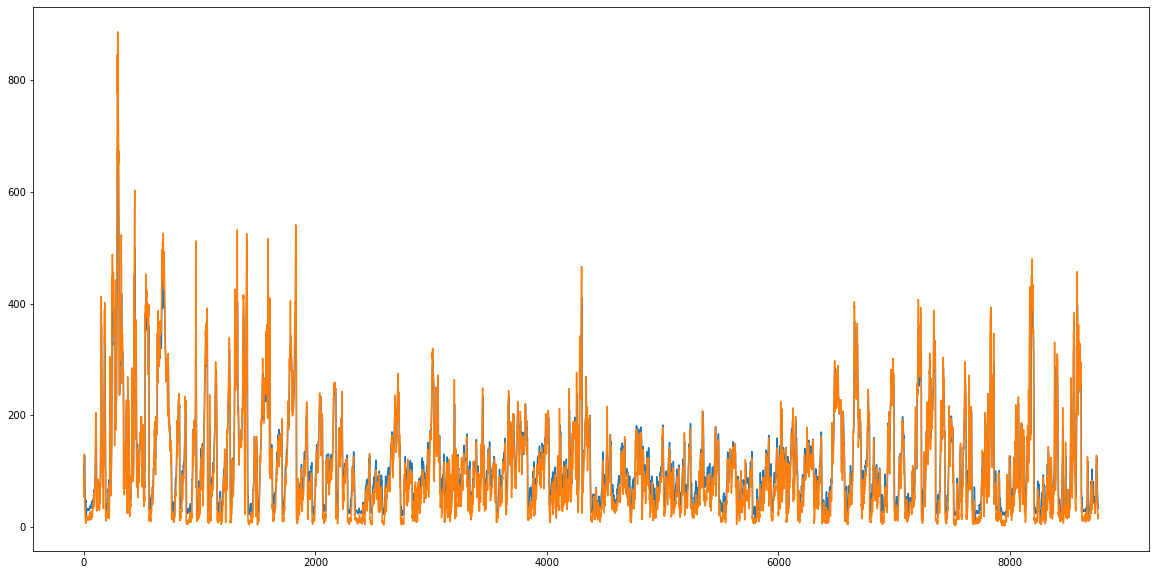

Saving...
Iter:  1 train:  0.02701436932292912 val:  0.024587940074147396
Iter:  2 train:  0.024302784875824095 val:  0.026356920334598848
Saving...
Iter:  3 train:  0.023850203900999685 val:  0.024030422749696728
Iter:  4 train:  0.02337916021897782 val:  0.024351373085328264
Saving...
Iter:  5 train:  0.023413883800850882 val:  0.023980166343145315
Iter:  6 train:  0.023548089204708737 val:  0.024118113353624085
Iter:  7 train:  0.02333111122851356 val:  0.024655154712790953
Iter:  8 train:  0.02329182645310653 val:  0.024158475012038664
Saving...
Iter:  9 train:  0.023258195207187343 val:  0.02384387324713166
Iter:  10 train:  0.023146762355135866 val:  0.02465453813279036
lr:  0.001
mse:  600.5739 mae:  13.889854


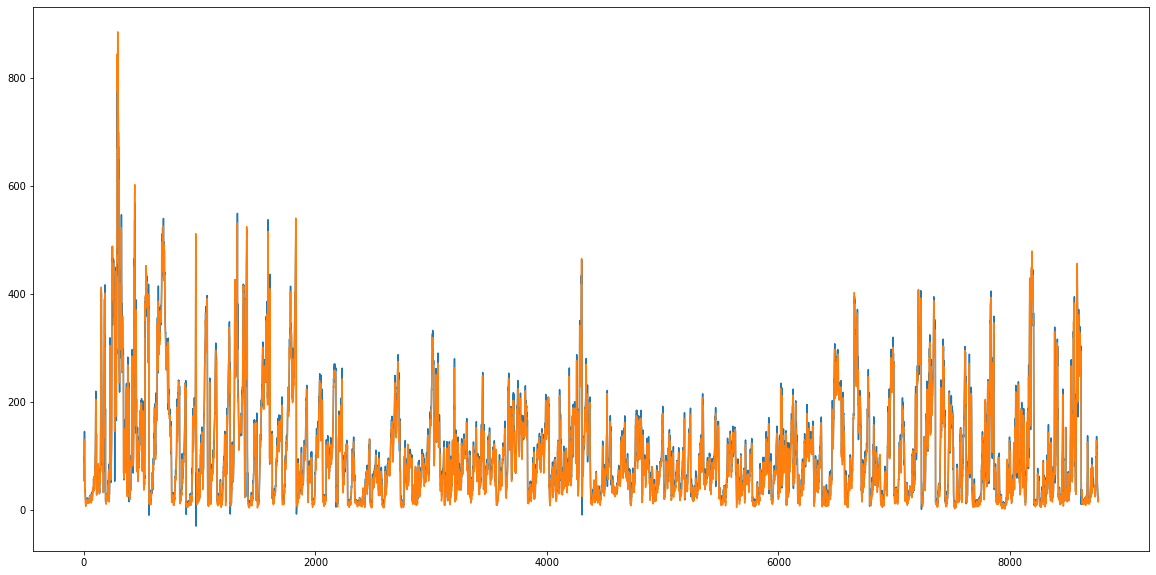

Iter:  11 train:  0.023187646595019564 val:  0.02405662759741978
Iter:  12 train:  0.023066212392362458 val:  0.02576252541155265
Iter:  13 train:  0.023069623534641454 val:  0.024244834477208804
Iter:  14 train:  0.02295633760352194 val:  0.023862487258624665
Saving...
Iter:  15 train:  0.02288131071966929 val:  0.023745858091786167
Iter:  16 train:  0.022792654885126287 val:  0.024167842755082953
Iter:  17 train:  0.02297653209482331 val:  0.024302942206938776
Iter:  18 train:  0.02292030804861088 val:  0.024028290648987302
Iter:  19 train:  0.022841770507984235 val:  0.023797140028189532
Saving...
Iter:  20 train:  0.022832975181258357 val:  0.02371307290859818
lr:  0.0009000000000000001
mse:  555.58234 mae:  12.657293


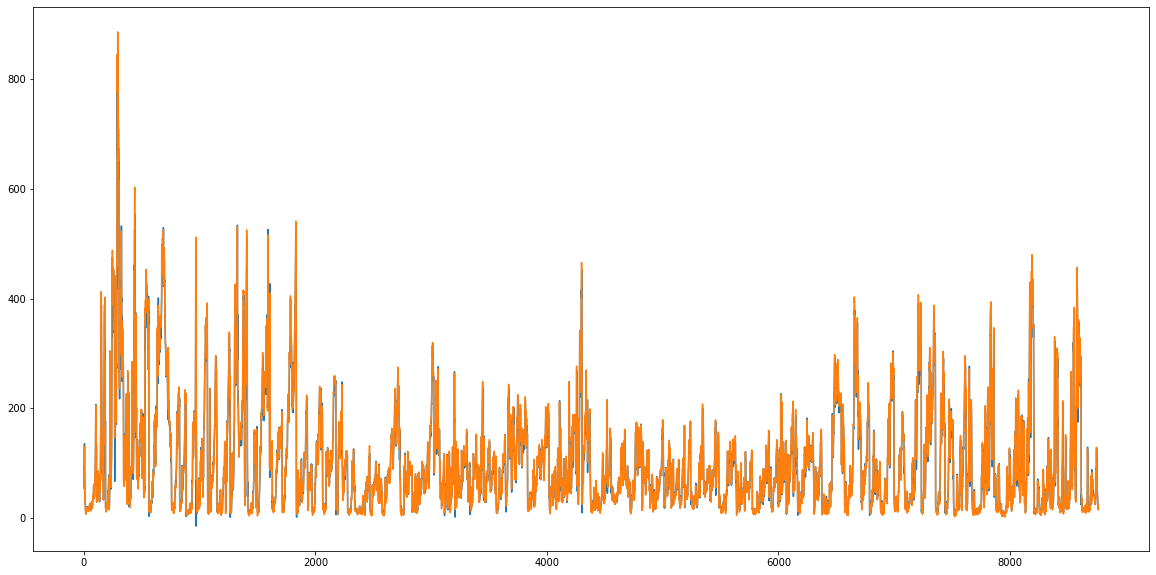

Iter:  21 train:  0.022705815409553444 val:  0.02391114779847509
Iter:  22 train:  0.022603962322910818 val:  0.024080340298348466
Iter:  23 train:  0.022595951711816754 val:  0.02427963977684777
Iter:  24 train:  0.022581298169373706 val:  0.02382511390637539
Iter:  25 train:  0.02257358171187471 val:  0.02447318635523973
Iter:  26 train:  0.022674948276328648 val:  0.023986497340164843
Saving...
Iter:  27 train:  0.022653314499050378 val:  0.023581909654359665
Iter:  28 train:  0.022568855999922522 val:  0.02364246672038602
Saving...
Iter:  29 train:  0.022532699066081092 val:  0.023539322460888287
Iter:  30 train:  0.022445170442303798 val:  0.023544504429199874
lr:  0.0009000000000000001
mse:  547.7116 mae:  12.804827


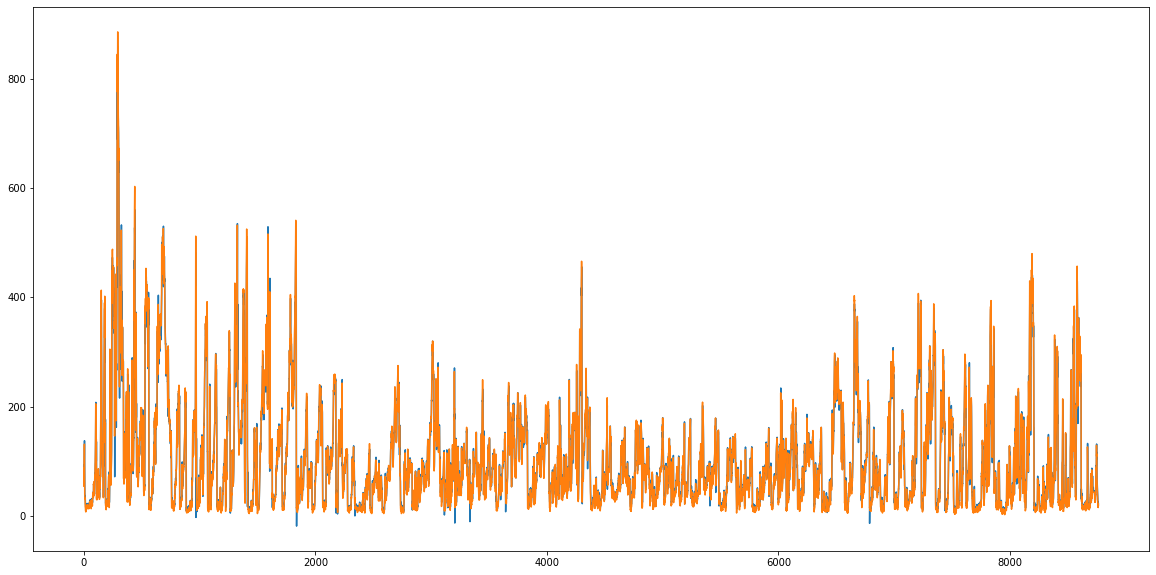

Iter:  31 train:  0.02261454990265479 val:  0.023664599682656336
Iter:  32 train:  0.02237648558832493 val:  0.023652067259207828
Saving...
Iter:  33 train:  0.02238476409724222 val:  0.02349952045187262
Iter:  34 train:  0.022368743613039213 val:  0.024673433964293435
Saving...
Iter:  35 train:  0.022543603585933 val:  0.0234732359304993
Iter:  36 train:  0.02259640432973813 val:  0.023642895011731863
Iter:  37 train:  0.022389261165037404 val:  0.023734150492716807
Iter:  38 train:  0.022345260222888092 val:  0.02348770239951062
Iter:  39 train:  0.022374286415113374 val:  0.023923666654076744
Iter:  40 train:  0.022264276621381678 val:  0.02349634707060955
lr:  0.0008100000000000001
mse:  545.47327 mae:  12.46753


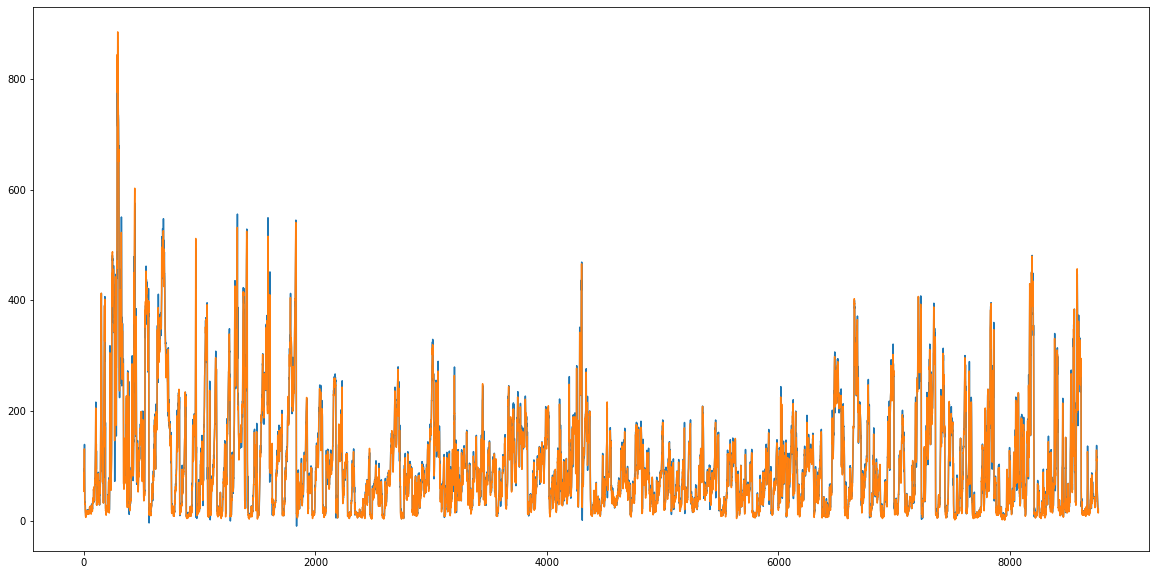

Saving...
Iter:  41 train:  0.022210292469003277 val:  0.023353132472076585
Iter:  42 train:  0.022212083233597003 val:  0.023381941367571563
Saving...
Iter:  43 train:  0.022242842767137647 val:  0.023310101210145498
Iter:  44 train:  0.022253921813340283 val:  0.02342811467084767
Iter:  45 train:  0.02222980843539045 val:  0.023401943873427415
Iter:  46 train:  0.022166657441254088 val:  0.02347119504062955
Iter:  47 train:  0.022129937376541474 val:  0.023624535669691797
Iter:  48 train:  0.022303902864084072 val:  0.023713233290442646
Iter:  49 train:  0.022180148014438093 val:  0.023353980533360356
Iter:  50 train:  0.022161969597252515 val:  0.023413832929533022
lr:  0.0008100000000000001
mse:  541.6488 mae:  13.102022


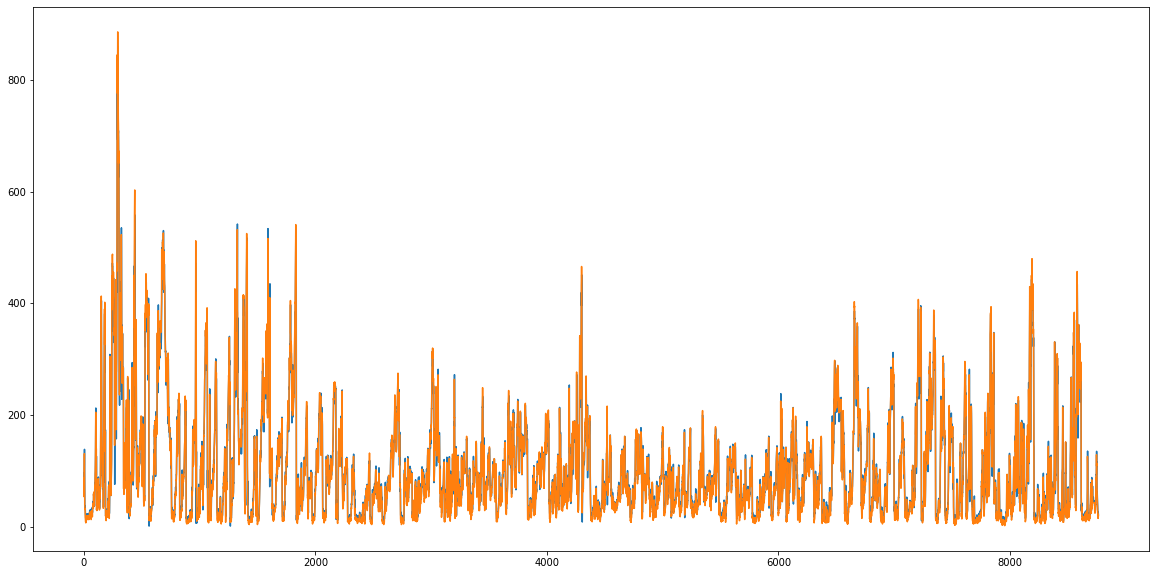

Iter:  51 train:  0.022085790189091493 val:  0.023526902287870712
Iter:  52 train:  0.022190267987393642 val:  0.02351330552964777
Iter:  53 train:  0.022245393118755705 val:  0.02380516471730547
Iter:  54 train:  0.022116771721648398 val:  0.02386080804560203
Saving...
Iter:  55 train:  0.02216994773903194 val:  0.023259638793111735
Iter:  56 train:  0.022059398381127027 val:  0.02331246186407535
Iter:  57 train:  0.022025045012683944 val:  0.023682380791224707
Iter:  58 train:  0.0220858067457908 val:  0.023449459228109825
Iter:  59 train:  0.02200458208749384 val:  0.023476202757439273
Iter:  60 train:  0.02205448627337933 val:  0.02330769255441067
lr:  0.000729
mse:  536.74915 mae:  12.721122


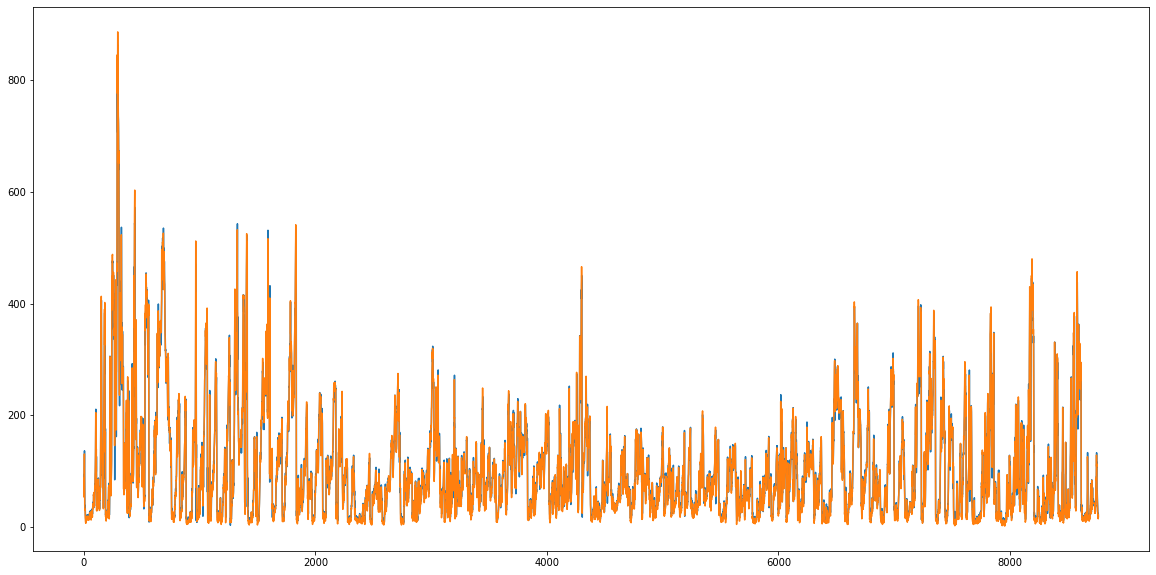

Iter:  61 train:  0.0220342842314673 val:  0.023266450207249396
Iter:  62 train:  0.02205767254796111 val:  0.023290902814585342
Iter:  63 train:  0.022050180702630724 val:  0.023293485702046327
Saving...
Iter:  64 train:  0.02201778456950049 val:  0.02324841607376963
Iter:  65 train:  0.021964639712452293 val:  0.023257390761338904
Iter:  66 train:  0.02195846495705591 val:  0.023632856210880106
Iter:  67 train:  0.021894755049088117 val:  0.023549017894831287
Iter:  68 train:  0.02197965916967558 val:  0.02346694445014534
Iter:  69 train:  0.022021058408998626 val:  0.023304608064779266
Iter:  70 train:  0.021953487421702413 val:  0.02362208424117016
lr:  0.000729
mse:  551.3269 mae:  12.845045


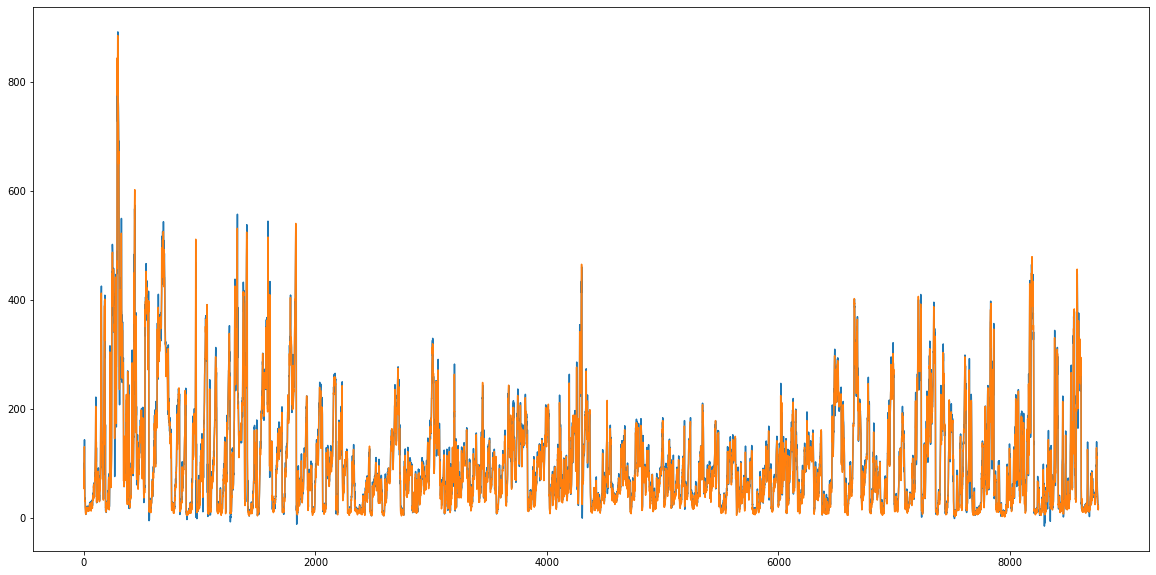

Iter:  71 train:  0.021923368449871722 val:  0.023445489710864388
Iter:  72 train:  0.022024882917209627 val:  0.023395977910350748
Iter:  73 train:  0.02187113325207152 val:  0.0235114566224332
Iter:  74 train:  0.0218567385337954 val:  0.023259442535356122
Iter:  75 train:  0.021892269941586426 val:  0.02332190645957432
Iter:  76 train:  0.022066068549163407 val:  0.023279529363176465
Saving...
Iter:  77 train:  0.021871675665220892 val:  0.0231997588578029
Iter:  78 train:  0.021837520747345594 val:  0.023406189541051194
Iter:  79 train:  0.021879808381841972 val:  0.02344006716609541
Iter:  80 train:  0.02177268002048631 val:  0.023324093648779826
lr:  0.0006561000000000001
mse:  537.5048 mae:  12.77097


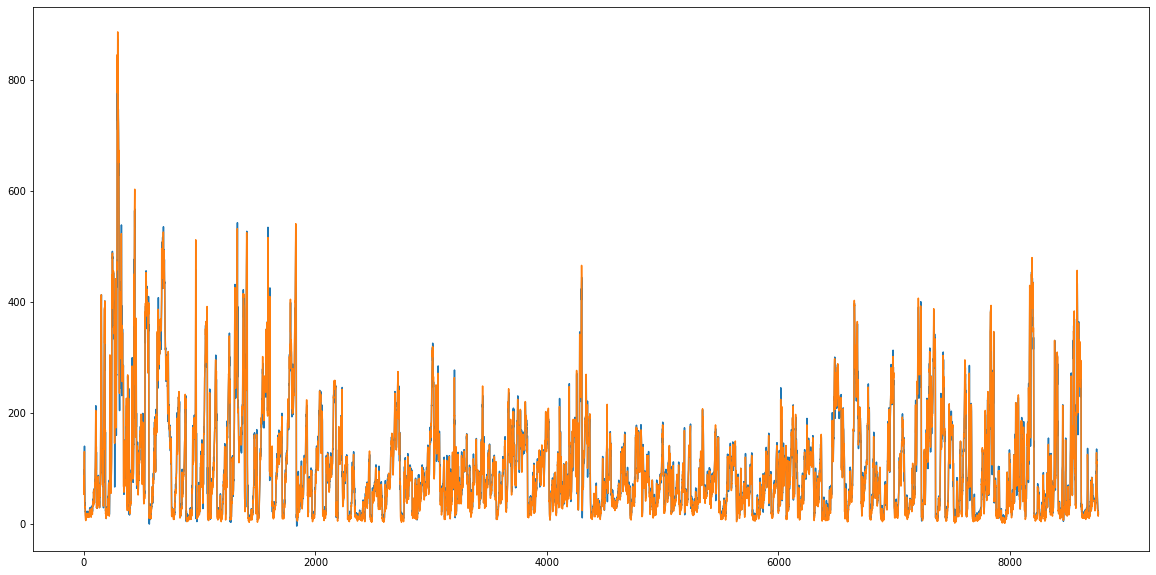

Iter:  81 train:  0.021809856069478908 val:  0.023321522106763363
Iter:  82 train:  0.021761707561884936 val:  0.02338637608350418
Iter:  83 train:  0.021760099284763964 val:  0.023306391487613664
Iter:  84 train:  0.02177902777098988 val:  0.023323254857790316
Iter:  85 train:  0.021790599572032193 val:  0.023402155373514727
Iter:  86 train:  0.0217089341239647 val:  0.02320782112339359
Iter:  87 train:  0.021755233408148097 val:  0.02361003045060459
Iter:  88 train:  0.021753772972118567 val:  0.023350706715118345
Iter:  89 train:  0.021714359499664538 val:  0.023531724318698266
Iter:  90 train:  0.021729207439628515 val:  0.023386524056510226
lr:  0.0006561000000000001
mse:  540.3861 mae:  12.533189


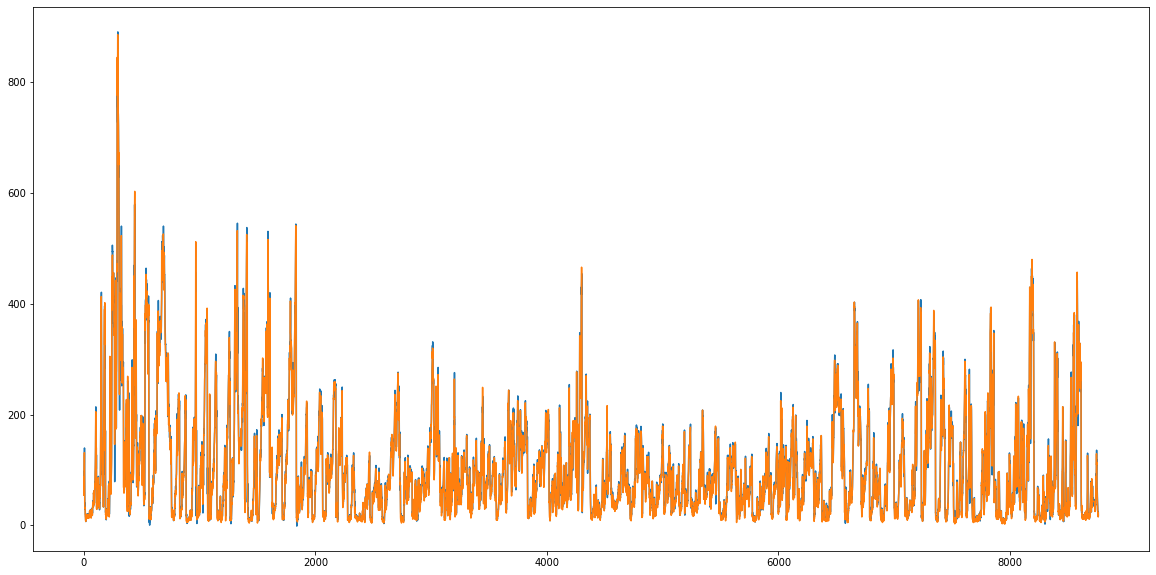

Iter:  91 train:  0.021763952004177373 val:  0.0233531830459014
Iter:  92 train:  0.02168586498888281 val:  0.02333545018018273
Iter:  93 train:  0.021695579033831586 val:  0.023375887975451422
Iter:  94 train:  0.021732572746729264 val:  0.023567403482376424
Iter:  95 train:  0.021688924812774634 val:  0.023351258090413583
Iter:  96 train:  0.021689395300841338 val:  0.023418057324549064
Saving...
Iter:  97 train:  0.021650344615291417 val:  0.023191430982802366
Iter:  98 train:  0.021653215253286034 val:  0.023351391230740173
Iter:  99 train:  0.021703305291634674 val:  0.023639895472006962
Iter:  100 train:  0.021694971466650777 val:  0.02346139472190421
lr:  0.00059049
mse:  543.85156 mae:  12.612369


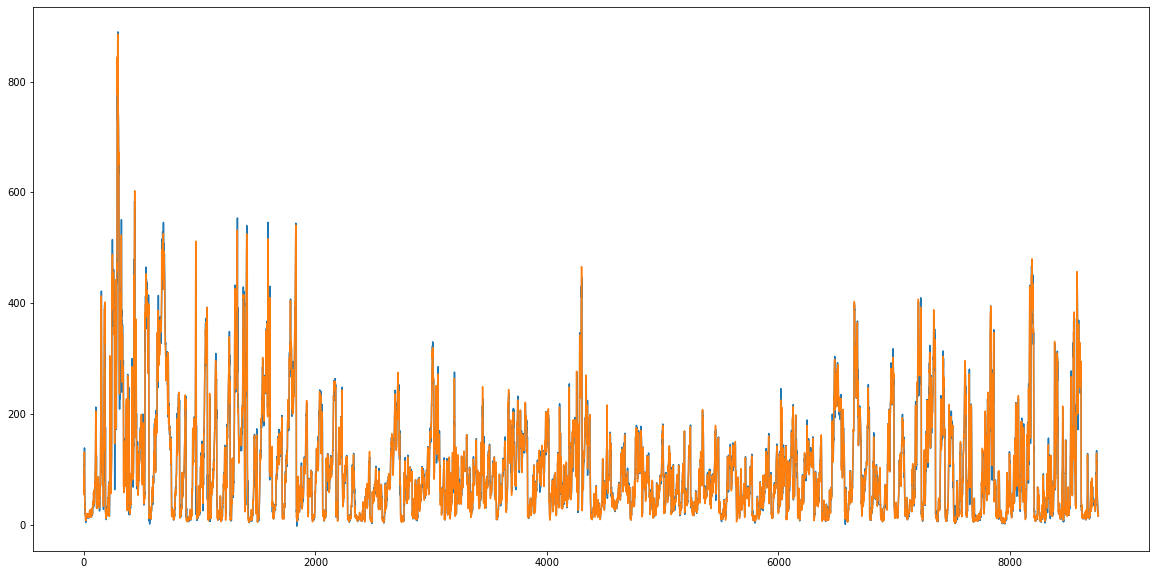

Iter:  101 train:  0.021604477510179496 val:  0.02331766253101089
Iter:  102 train:  0.021561271404978006 val:  0.023432069102843837
Iter:  103 train:  0.021605672635664146 val:  0.02333649505981734
Iter:  104 train:  0.02158801480814741 val:  0.023295026926681946
Iter:  105 train:  0.021611615058406294 val:  0.0236666034115127
Iter:  106 train:  0.02158856295583051 val:  0.02329211576211978
Iter:  107 train:  0.02154289198816992 val:  0.02341722011049545
Iter:  108 train:  0.021684548337456575 val:  0.023335993221623292
Iter:  109 train:  0.021531553719253207 val:  0.023307213200865106
Iter:  110 train:  0.02154857483438465 val:  0.023506224456785588
lr:  0.00059049
mse:  545.932 mae:  12.623866


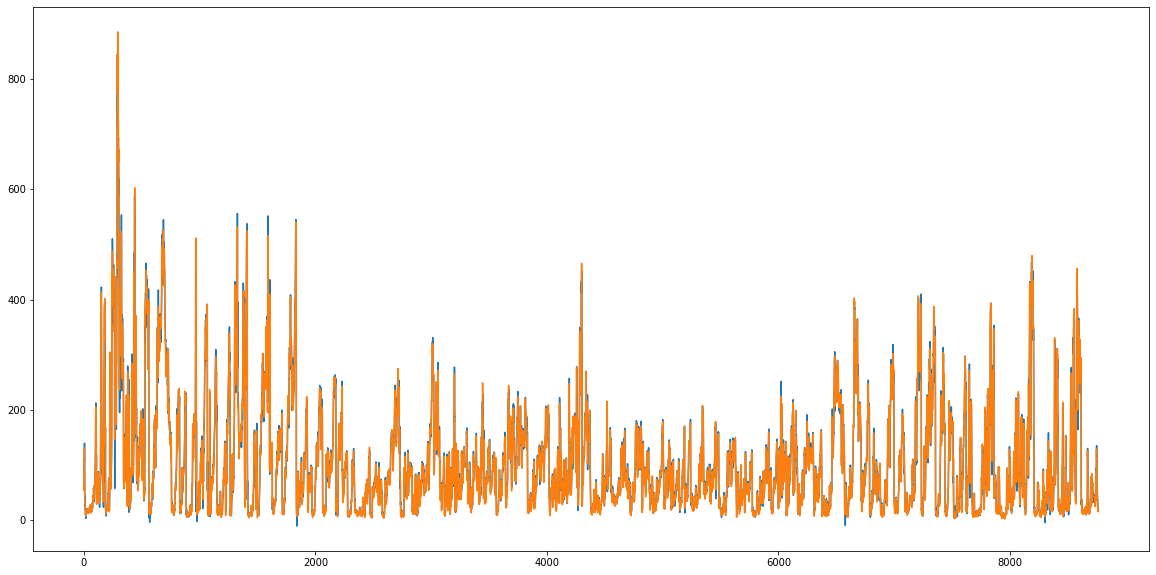

Iter:  111 train:  0.021515082967301206 val:  0.023537889166054846
Iter:  112 train:  0.021499363212281998 val:  0.02336622358868747
Iter:  113 train:  0.02151292481885087 val:  0.023658165458428523
Iter:  114 train:  0.02152174182746836 val:  0.02354055683529916
Iter:  115 train:  0.021508168051003643 val:  0.023332487239974692
Iter:  116 train:  0.021487343912823177 val:  0.023284157426110185
Iter:  117 train:  0.021471416557429797 val:  0.023930481828102045
Iter:  118 train:  0.021550127327320753 val:  0.02385325121188196
Iter:  119 train:  0.021482196872470806 val:  0.023345872220290036
Iter:  120 train:  0.02141746646054093 val:  0.02337524602404337
lr:  0.000531441
mse:  539.865 mae:  12.870694


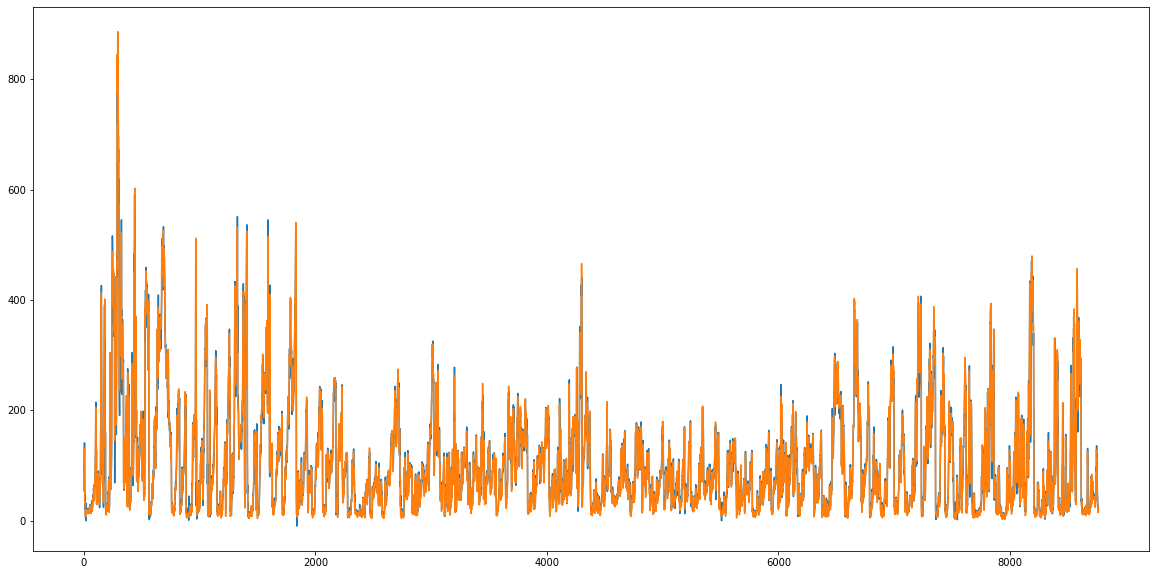

Iter:  121 train:  0.0214358866780268 val:  0.02338277013924102
Iter:  122 train:  0.021401565312164385 val:  0.023588916235658675
Iter:  123 train:  0.021415756697462953 val:  0.02370108214981104
Iter:  124 train:  0.0213906049694595 val:  0.023529493667206382
Iter:  125 train:  0.021379901322449026 val:  0.023642558818716235
Iter:  126 train:  0.02137912273181134 val:  0.02356194491633596
Iter:  127 train:  0.0213580522699972 val:  0.02342954096972982
Iter:  128 train:  0.02135847615365762 val:  0.023565219885121627
Iter:  129 train:  0.021324491041764225 val:  0.02342478230098804
Iter:  130 train:  0.02135274460736755 val:  0.023732471036042764
lr:  0.000531441
mse:  556.4917 mae:  13.032875


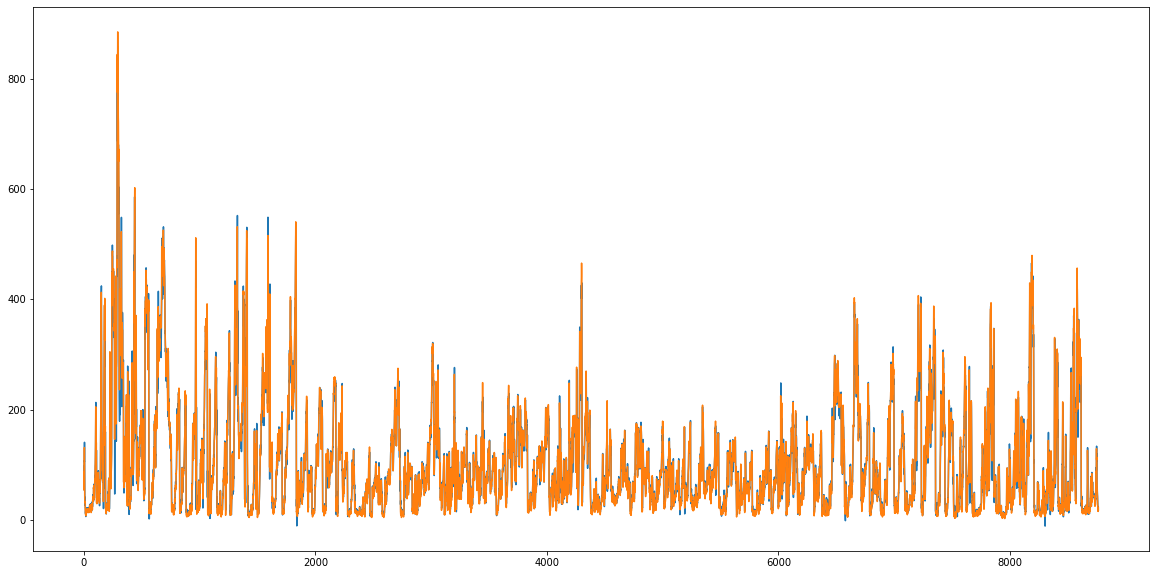

Iter:  131 train:  0.02131572550093521 val:  0.02433174352984215


In [165]:
epochs = 1000
loss = nn.MSELoss()
patience = 35
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_tensor_lstm_pm25.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("lr: ", opt.param_groups[0]["lr"])
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [167]:
model.load_state_dict(torch.load("imv_tensor_lstm_pm25.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [174]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas = []
    betas = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        alphas.append(a.detach().cpu().numpy())
        betas.append(b.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

In [175]:
preds = preds*(y_train_max - y_train_min) + y_train_min
true = true*(y_train_max - y_train_min) + y_train_min

In [176]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [177]:
mse, mae

(435.47485, 11.291735)

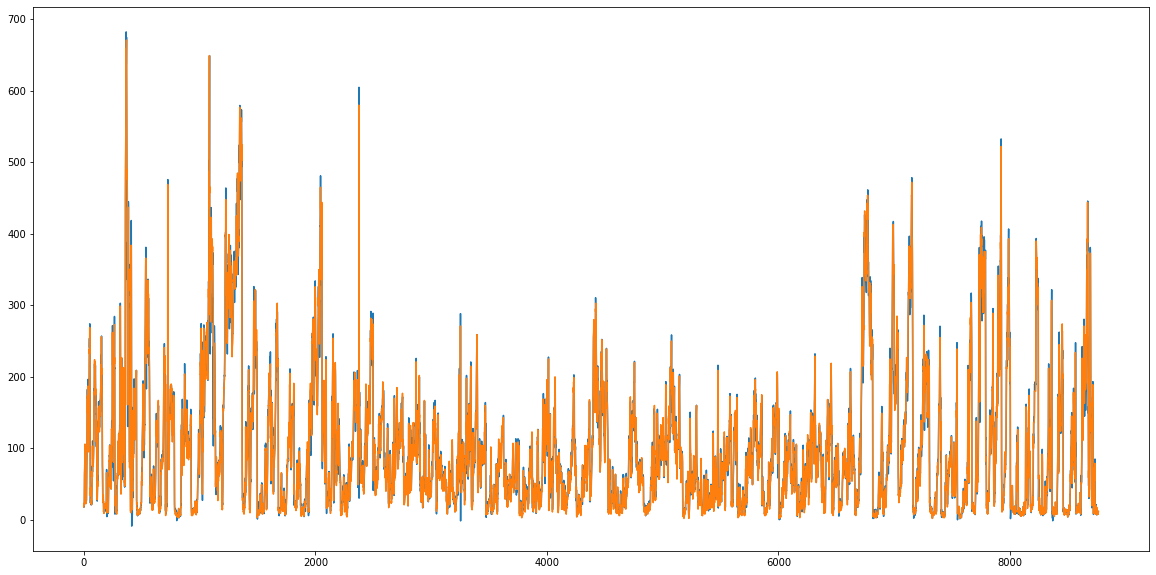

In [178]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

In [179]:
alphas = np.concatenate(alphas)
betas = np.concatenate(betas)

In [180]:
alphas = alphas.mean(axis=0)
betas = betas.mean(axis=0)

In [181]:
alphas = alphas[..., 0]
betas = betas[..., 0]

In [182]:
alphas = alphas.transpose(1, 0)

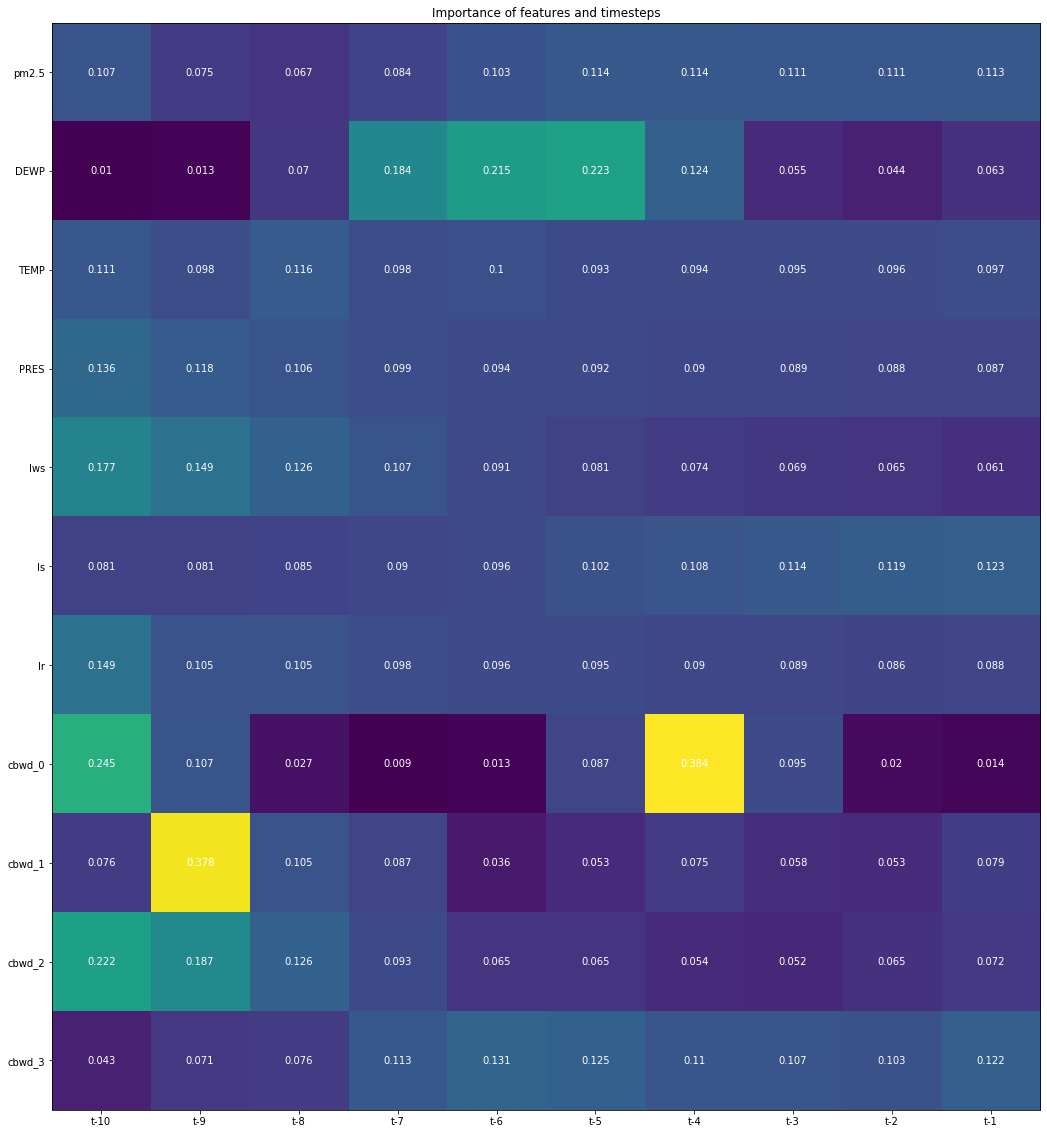

In [184]:
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(alphas)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], -1, -1)])
ax.set_yticklabels(list(cols))
for i in range(len(cols)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Importance of features and timesteps")
#fig.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x7fb86ccc5eb8>,
 <a list of 11 Text xticklabel objects>)

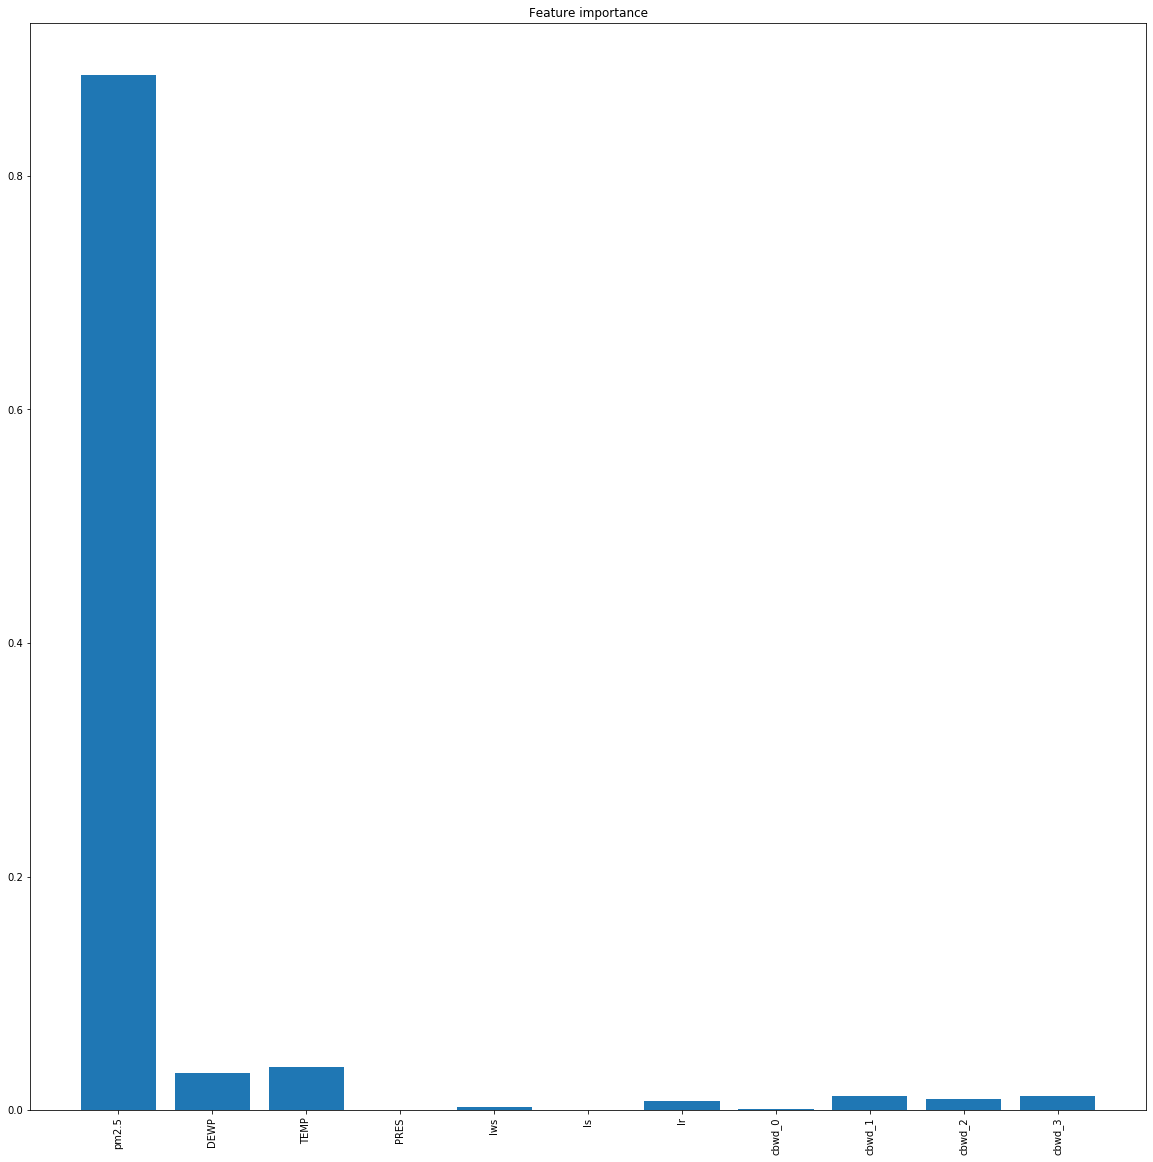

In [187]:
plt.figure(figsize=(20, 20))
plt.title("Feature importance")
plt.bar(range(len(cols)), betas)
plt.xticks(ticks=range(len(cols)), labels=cols, rotation=90)